# SMA

In [11]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

**DATA IMPORT**

In [12]:
# Read data in to dataframes
nabil = pd.read_csv('../Data/NABILModifiedDate.csv')

# Change date column to datetime type
nabil['Date'] = pd.to_datetime(nabil['Date'])

In [13]:
nabil.tail(100)

,Date,Open,High,Low,Close,Percent Change,Volume
2045,2022-07-27,866.0,870.0,853.0,866.0,0.00,43850
2046,2022-07-28,880.0,880.0,865.0,866.0,0.00,43396
2047,2022-07-29,866.0,880.0,865.0,869.9,0.45,17497
2048,2022-07-31,879.0,882.0,871.0,881.0,1.28,52796
2049,2022-08-01,894.9,897.5,880.0,881.9,0.10,47675
...,...,...,...,...,...,...,...
2140,2022-12-22,809.0,811.0,800.1,810.0,0.37,66052
2141,2022-12-26,811.0,840.0,811.0,838.0,3.46,110057
2142,2022-12-27,847.0,860.0,834.0,842.0,0.48,133855
2143,2022-12-28,845.0,847.0,826.1,834.9,-0.84,105429


In [14]:
nabil.dropna(inplace=True)

### NABIL Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 2200 time steps. We know that our data is in days, so our data is just shy of 2200 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [15]:
series = nabil['Close']

# CREATE THE TRAIN TEST DATASET
train_split_date = '2019-12-31'
train_split_index = np.where(nabil.Date == train_split_date)[0][0]
x_train = nabil.loc[nabil['Date'] <= train_split_date]['Close']

# CREATE THE TEST DATASET
test_split_date = '2021-01-03'
test_split_index = np.where(nabil.Date == test_split_date)[0][0]
x_test = nabil.loc[nabil['Date'] >= test_split_date]['Close']

# CREATE THE VALIDATION DATASET
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = nabil.loc[(nabil['Date'] < test_split_date) & (nabil['Date'] > train_split_date)]['Close']

1479 1480 1663 1664 2144


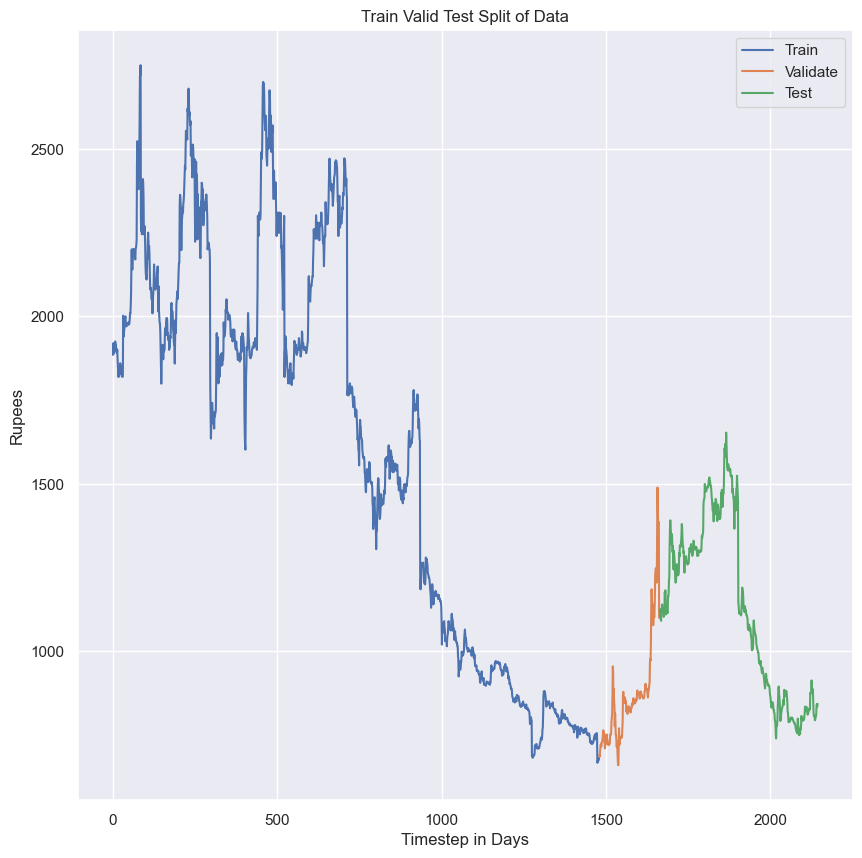

In [16]:
# SET STYLE OF CHARTS
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Rupees')
plt.xlabel('Timestep in Days')
plt.legend()
plt.savefig('../Images/SMA/SMA TRAIN TEST SPLIT')
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

# Monthly Moving Average Model (20 Day MA)
Moving Averages are valuable tools used to smooth out data and remove its short-term fluctuations, making trends easier to identify. When someone talks about "de-trending" or "smoothing" data, they often refer to implementing some form of moving average. It's not a true prediction model, but it serves as a demonstration of data manipulation. There are two common types of moving averages: Simple Moving Average (SMA) and Exponential Moving Average (EMA). SMA calculates the average price or value over a specific time span, like finding the typical value over the last 10 days. On the other hand, EMA is a bit more sophisticated. It assigns weight factors to each time step in the window, giving more importance to recent data and making it more responsive to abrupt changes. This responsiveness allows EMA to adapt quickly to fluctuations in the data, providing a smoother and more dynamic representation of the underlying trends. In summary, moving averages are useful tools for "smoothing out the bumps" in data, helping analysts and traders better understand and interpret trends in various fields, from finance to scientific research.

/Users/bijay/FINAL THESIS/PredictIt/Comparative Analysis/Notebooks/formulas.py:79: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format, label=label)


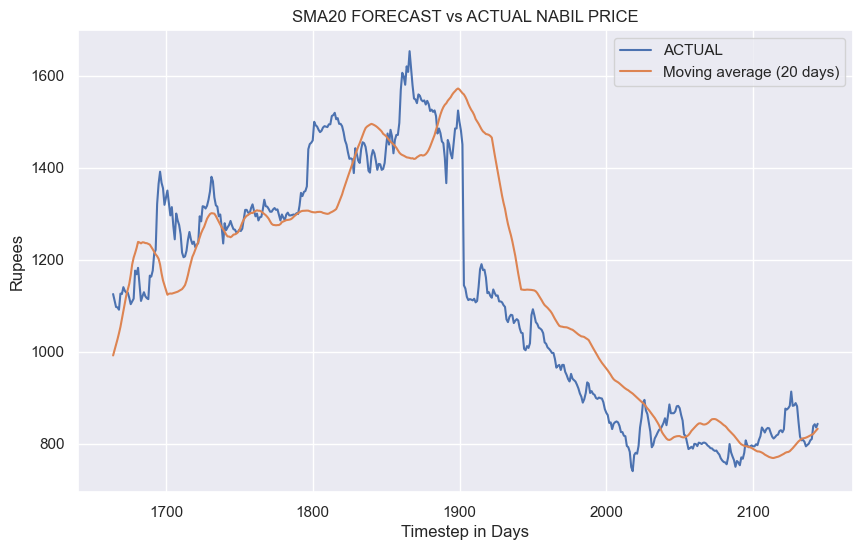

MAE FOR SMA20 IS: 88.50874220374219


<Figure size 1000x1000 with 0 Axes>

In [17]:
# CHOOSE A WINDOW SIZE FOR THE MOVING AVERAGE
window = 20

# CREATE A MOVING AVERAGE OVER THE ENTIRE DATASET
moving_avg = nabil['Close'].rolling(window=window).mean()

# SLICE THE MOVING AVERAGE ON THE FORECAST
moving_avg_forecast = moving_avg.iloc[test_split_index - window:nabil.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="ACTUAL")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Rupees')
plt.xlabel('Timestep in Days')
plt.title('SMA20 FORECAST vs ACTUAL NABIL PRICE')
plt.legend()
plt.show()
plt.savefig('../Images/SMA/SMA20 FORECAST VS ACTUAL')
# CALCULATING MAE OF MA 20
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
print(f"MAE FOR SMA20 IS: {ma_20}")


In [18]:
# CALCULATING MAE OF MA 20
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
print(ma_20)

88.50874220374219


# Weekly Moving Average (5 day MA)
I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the NABIL. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

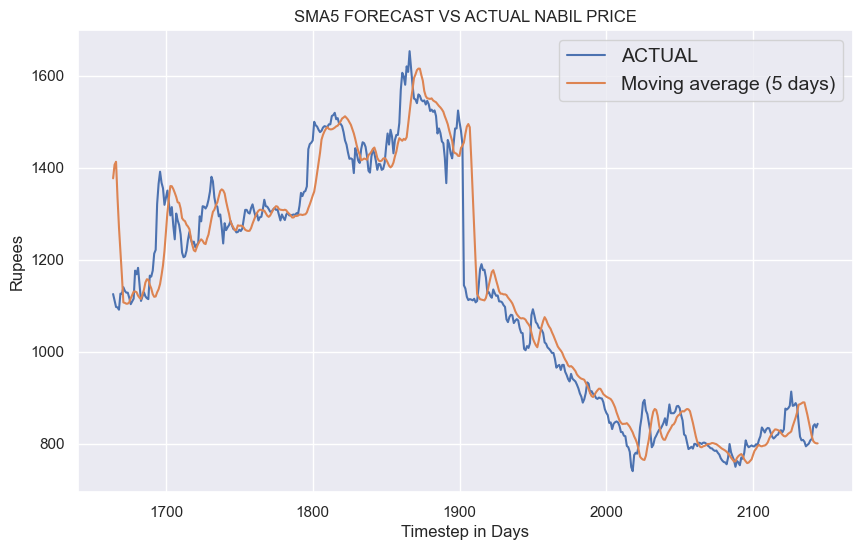

MAE FOR SMA5 IS: 45.33717255717256


<Figure size 1000x1000 with 0 Axes>

In [19]:
# CHOOSE A WINDOW SIZE FOR THE MOVINF AVERAGE
window = 5

# CREATE A MOVING AVERAGE OVER THE ENTIRE DATASET
moving_avg = nabil['Close'].rolling(window=window).mean()

# SLICE THE MOVING AVERAGE ON THE FORECAST
moving_avg_forecast = moving_avg.values[test_split_index - window:nabil.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="ACTUAL")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Rupees')
plt.xlabel('Timestep in Days')
plt.title('SMA5 FORECAST VS ACTUAL NABIL PRICE')
plt.show()
plt.savefig('../Images/SMA/SMA5 FORCAST VS ACTUAL')
# CALCULATE MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
print(f"MAE FOR SMA5 IS: {ma_5}")

In [20]:
# CALCULATE MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()
print(ma_5)

45.33717255717256
